# Лабораторная работа №1. Градиентный спуск

Рассмотрим задачу оптимизации: 

$min$ { $(x−μ_{0})^T A(x−μ_{0}) : ∥x∥^2_2 ≤ 1 $ },

где $x∈R^n$, $A$ - симметричная, положительно определенная матрица, $μ_{0}= (1, 1, . . . , 1)^⊤∈R^n$.
1) Исследовать задачу на выпуклость.
2) Для каждого значения $n∈\{10, 20, ..., 100\}$ сгенерировать $N=100$ тестовых примеров. В каждом случае найдите глобальный минимум, $x^∗∈R^n$, с помощью CVX. Проверьте, что в точке минимума выполняется условие оптимальности (т.е. вектора градиента к ограничению и антиградиента к целевой функции сонаправлены).
3) Для каждого значения $n∈\{10, 20, ..., 100\}$ и для каждого тестового примера $N_i,\ i$ от 1 до 100 сгенерировать по $P=100$ начальных точек. В зависимости от варианта реализуйте следующие методы решения задачи для заданной точности $ε=0.01$ (Используйте в качестве точности либо разность между текущим значением функции и оптимальным (из солвера), либо некоторую меру выполнения условий оптимальности):
    * Gradient descent for strongly convex and Lipschitz functions ([Section 3.4.1, Theorem 3.9](https://arxiv.org/pdf/1405.4980#page=50));
    * Gradient descent for smooth functions ([Section 3.2, Theorem 3.7](https://arxiv.org/pdf/1405.4980#page=43));
    
    * Gradient descent for strongly convex and smooth functions ([Section 3.4.2, Theorem 3.12](https://arxiv.org/pdf/1405.4980#page=52));
    * Conditional gradient descent, aka Frank-Wolfe ([Section 3.3, Theorem 3.8](https://arxiv.org/pdf/1405.4980#page=45));
    * Exact line search ([Section 9.2](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=477));
    * Backtracking line search  ([Section 9.2](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=477)).
4) Объясните принцип работы метода, опишите его преимущества и недостатки.
5) В качестве результата работы метода:
    * Для каждого значения $n∈\{10, 20, ..., 100\}$ подсчитайте среднее время работы метода и среднее число итераций (усреднение проводится по всем начальным точкам и по всем тестовым примерам);
    * Для одного тестового примера при $n=10$ и нескольких различных начальных точек постройте зависимость точности от числа итераций. Зависит ли скорость сходимости метода от отношения максимального и минимального собственных чисел матрицы *A*? Сравните полученные результаты с теоретическими верхними оценками (только для вариантов 1-4, обратите внимание, что для сравнения с теоретическими верхними оценками необходимо считать точность тем же способом, как это делается в соответствующей оценке).
6) Оформите отчет с последовательным изложением пунктов 1-5 и выводами.

In [1]:
import cvxpy as cp
import numpy as np
from sklearn.datasets import make_spd_matrix

import time
from tqdm import tqdm
from matplotlib import pyplot as plt

In [227]:
n = np.arange(10, 101, 10) # размерность пространства
N = 100 # число тестов
P = 100 # число начальных точек
ε = 0.01 # необходимая точность

### 1) Исследовать задачу на выпуклость

$f(x) = (x−μ_{0})^⊤ A(x−μ_{0})$

$\nabla (x)^⊤ A(x) = 2Ax$, т.к. А - симметрична по условию задачи.

Функция $f(x)$ — квадратичная. Она выпукла тогда и только тогда, когда матрица $A$ — положительно определена, то есть по критерию Сильвестра — когда все её угловые миноры $\Delta_i$, размеров i × i, где i пробегает все целые числа от 1 до n включительно, положительны. По условию задачи матрица $A$ симметрична и положительно определена, т.е. $(x)^⊤ A(x)$ выпукла. Т.к. $f(x)$ - сдвиг $(x)^⊤ A(x)$ на вектор $μ_{0}$, что не влияет на выпуклость, то функция $f(x)$ выпукла.

Ограничение иммет вид $c(x) = ∥x∥^2_2 ≤ 1 = \sum_{i=1}^n x^2_i ≤ 1$

$\nabla c(x) = 2x$

Если выполняется неравенство Йенсена, т.е. если для $∀\lambda ∈$ отрузку $[0, 1]$ выполняется неравенство: $f(\lambda x + (1-\lambda)y) ≤ \lambda f(x) + (1-\lambda)f(y)$, то функция является выпуклой.

Проверим заданную функцию $(x−μ_{0})^⊤A(x−μ_{0})$ на выпуклость по определению, если $x∈R^n$, $A$ - симметричная, положительно определенная матрица, $μ_{0}= (1, 1, . . . , 1)^⊤∈R^n$.

In [318]:
def function(x: np.array, A: np.array, mu: np.array) -> float:
    return ((x-mu).T @ A @ (x-mu))

In [319]:
mu = np.ones(10)
A =  make_spd_matrix(10)
x =  np.random.rand(10)
y =  np.random.rand(10)
result = []

for i in range(N):
    test_lambda = np.random.uniform(low=0, high=1)
    if function(test_lambda*x+(1-test_lambda)*y, A, mu) <= test_lambda * function(x, A, mu) + (1-test_lambda) * function(y, A, mu):
        result.append(True)

all(result)

True

### 2) Для каждого значения $n∈\{10, 20, ..., 100\}$ сгенерировать $N=100$ тестовых примеров. В каждом случае найдите глобальный минимум, $x^∗∈R^n$, с помощью CVX. Проверьте, что в точке минимума выполняется условие оптимальности (т.е. вектора градиента к ограничению и антиградиента к целевой функции сонаправлены).

In [261]:
def check_optimal(x: np.array, A: np.array, mu: np.array) -> bool:
    grad_const = 2 * x
    grad_func = 2 * A @ (x - mu)
    return grad_const.T @ - grad_func > 0

In [320]:
result_A = []
reult_X_opt_solver = []
result_solver = []
for dim in tqdm(n):
    for i in range(N):
        A = make_spd_matrix(dim)
        x = cp.Variable(dim)
        mu = np.ones(dim)
        optimization_func = cp.quad_form(x-mu, A)
        objective = cp.Minimize(optimization_func)
        constraints = [cp.sum_squares(x) <= 1]
        problem = cp.Problem(objective, constraints)
        res = problem.solve(solver=cp.SCS)

        check_optimal(x.value, A, mu)
        result_A.append(A)
        reult_X_opt_solver.append(x.value)
        result_solver.append(res)

100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


In [327]:
result_A

[array([[ 1.19772913,  1.47267089,  0.09343691, -0.77536852,  0.37866515,
         -0.75805825, -1.00642016,  0.13553666, -1.20471906, -0.83099057],
        [ 1.47267089,  3.19151931,  0.33995536, -1.39440897,  0.4646601 ,
         -1.30340132, -2.12869881, -0.11427967, -2.49546812, -1.55790066],
        [ 0.09343691,  0.33995536,  0.65628282, -0.13707314,  0.04066005,
         -0.18284678, -0.32941413,  0.07288028, -0.20568673, -0.34254053],
        [-0.77536852, -1.39440897, -0.13707314,  1.49290792, -0.23525105,
          0.87863768,  1.23085421,  0.00598045,  1.2852603 ,  0.78983276],
        [ 0.37866515,  0.4646601 ,  0.04066005, -0.23525105,  0.77384002,
         -0.35386168, -0.37642902, -0.13606355, -0.40203287, -0.36919666],
        [-0.75805825, -1.30340132, -0.18284678,  0.87863768, -0.35386168,
          1.1043494 ,  1.15575202,  0.04839576,  1.23313515,  1.05039187],
        [-1.00642016, -2.12869881, -0.32941413,  1.23085421, -0.37642902,
          1.15575202,  2.0327674

In [328]:
reult_X_opt_solver

[array([ 0.15752891, -0.01638674,  0.15884947,  0.40697426,  0.15865054,
         0.35265558,  0.42306505,  0.24989166,  0.50626958,  0.36983827]),
 array([-0.2067457 ,  0.0779017 ,  0.27704549,  0.39006793,  0.42317913,
         0.53360606, -0.15105609,  0.18426841,  0.44072969, -0.08630713]),
 array([0.34531471, 0.01170969, 0.2060613 , 0.27829745, 0.48182442,
        0.53602825, 0.07727716, 0.0156448 , 0.34468706, 0.34088675]),
 array([ 0.09740608,  0.41441864,  0.27657777,  0.41891974,  0.39433696,
        -0.09714129,  0.38136774,  0.50544717, -0.01732981,  0.02501416]),
 array([ 0.56365301,  0.36161867,  0.15439801,  0.42870036,  0.31113273,
         0.40119693,  0.16426145,  0.22722094,  0.06517479, -0.05730265]),
 array([ 0.47105859,  0.57822263,  0.32519937,  0.36955472,  0.21286592,
         0.26498886,  0.07933037,  0.15690602,  0.16810001, -0.16351477]),
 array([0.2876266 , 0.37985683, 0.19484328, 0.22519551, 0.22720455,
        0.20787387, 0.1510069 , 0.19481956, 0.66376714

In [329]:
result_solver

[3.9835134169467836,
 0.4110830415662307,
 4.074045331147048,
 4.666061079165302,
 4.059063124505381,
 0.7895511953805351,
 3.6741425386711755,
 5.087574812254491,
 5.489326148182821,
 4.30697781188183,
 1.7653624711437392,
 2.502025548509041,
 5.921007556975319,
 3.203543562801654,
 3.1228313962750134,
 1.3597646549463722,
 4.563737144008124,
 5.436238200198671,
 6.36202929745398,
 2.618409430717704,
 4.532294511166759,
 3.1543440766194073,
 5.252255689512914,
 3.9996863667170706,
 4.8831739392879845,
 1.7621632910965777,
 6.050408408138326,
 4.653192560174934,
 2.008379499231374,
 3.5165329274137096,
 4.005894256123044,
 0.8612071881906287,
 4.718664150449876,
 0.4348666574294222,
 0.943634326131811,
 4.735850332670222,
 3.5259179170689996,
 0.7215173462019806,
 4.937934005223324,
 5.744558904386935,
 4.014305546818755,
 0.4945945677685414,
 6.080747184127086,
 2.031305793316537,
 2.5874720579018464,
 6.2154412206634735,
 1.466844822742705,
 4.850336540358162,
 0.3446464935193632,
 1

### 3) Для каждого значения $n∈\{10, 20, ..., 100\}$ и для каждого тестового примера $N_i,\ i$ от 1 до 100 сгенерировать по $P=100$ начальных точек. В зависимости от варианта реализуйте следующие методы решения задачи для заданной точности $ε=0.01$ (Используйте в качестве точности либо разность между текущим значением функции и оптимальным (из солвера), либо некоторую меру выполнения условий оптимальности)
Gradient descent for strongly convex and smooth functions ([Section 3.4.2, Theorem 3.12](https://arxiv.org/pdf/1405.4980#page=52));

$f(x_{t+1}) − f(x^∗) ≤ \frac{β}{2}e^{−\frac{4t}{k+1}}∥x_1-x^*∥^2$, где $k=\frac{β}{α}$.

In [355]:
def gradient_descent(x: np.array, A: np.array, res_solver: float, ε: float):
    iterations = 0

    eigenvalues_matrix = np.linalg.eigvals(A)
    alpha = 2 * eigenvalues_matrix.min()
    beta = 2 * eigenvalues_matrix.max()
    step = 2 / (alpha + beta)

    dim = x.shape[0]
    mu = np.ones(dim)
    constraint_center = np.zeros(dim)

    res_grad = function(x, A, mu)
    while abs(res_solver - res_grad) > ε:
        x = x - step * 2 * A @ (x - mu)
        if ((x - constraint_center)**2).sum()**(1/2) > 1:
            x = x / ((x - constraint_center)**2).sum()**(1/2)
        res_grad = function(x, A, mu)
        iterations += 1

    return iterations

In [356]:
Average_time = []
Average_iterations = []
for dim in tqdm(n):
    iterations = 0
    time_start = time.time()

    for i in range(N):
        A = result_A[10*(dim-10)+i]
        res_solver = result_solver[10*(dim-10)+i]
        
        for p in range(P):
            x = np.random.randint(low=0, high=100, size=dim)
            x = x/np.linalg.norm(x, ord=2)

            iterations += gradient_descent(x, A, res_solver, ε)
    
    Average_time.append((time.time() - time_start) / (N * P))
    Average_iterations.append(iterations / (N * P))

100%|██████████| 10/10 [03:09<00:00, 18.97s/it]


In [357]:
Average_time

[0.00025648195743560793,
 0.000379111909866333,
 0.0005026485681533814,
 0.000747194504737854,
 0.0008994356632232666,
 0.00120519859790802,
 0.0015684906482696533,
 0.0022004294157028197,
 0.0027672055721282957,
 0.008440114855766297]

In [358]:
Average_iterations

[4.9766,
 7.2857,
 7.7204,
 8.582,
 10.1782,
 11.1083,
 11.0835,
 12.2856,
 12.724,
 12.446]

### 4) Объясните принцип работы метода "Gradient descent for α-strongly convex and β-smooth functions with projection", опишите его преимущества и недостатки.

Теорема: Если $f$ это β-smooth и α-strongly convex function на $R^n$. Тогда градиентный спуск с шагом $step = \frac{2}{α+β}$ удовлетворяет выражению (скорость сходимости)

$f(x_{t+1}) − f(x^∗) ≤ \frac{β}{2}e^{−\frac{4t}{k+1}}∥x_1-x^*∥^2$, где $k=\frac{β}{α}$.

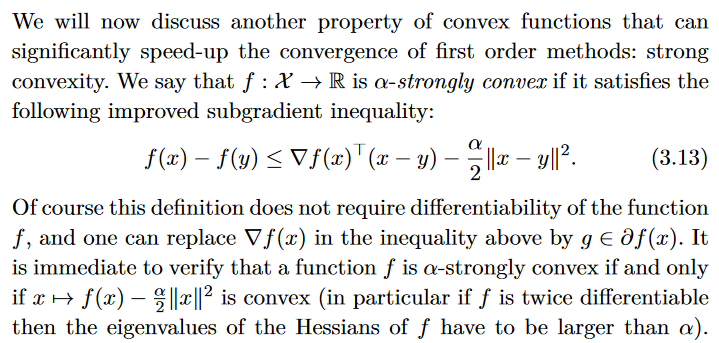

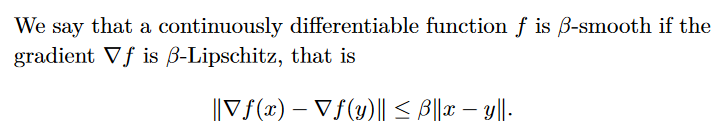

Преимущества:
* Благодаря условию, что рассматриваемая функция α-strongly convex и β-smooth — шаг для градиентного спуска $step = \frac{2}{α+β}$ и скорость сходимости ограничена выражением: <br>
$f(x_{t+1}) − f(x^∗) ≤ \frac{β}{2}e^{−\frac{4t}{k+1}}∥x_1-x^*∥^2$, где $k=\frac{β}{α}$.
    * Константный шаг $step = \frac{2}{α+β}$, зависящий только от параметров *α* и *β* рассматриваемой функции.
    * Линейная скорость сходимости.
* *Strongly-convex* и *smooth* функции могут быть оптимизированы даже при больших размерностях и с очень высокой точностью.

Недостатки:
* Требуется выполнение условий α-strongly convex и β-smooth функций 
* Градиентный спуск может застрять на локальном минимуме в случае, если не выполнено условие выпуклости.

### 5) Результаты работы метода

#### Среднее время и число итераций градиентного спуска

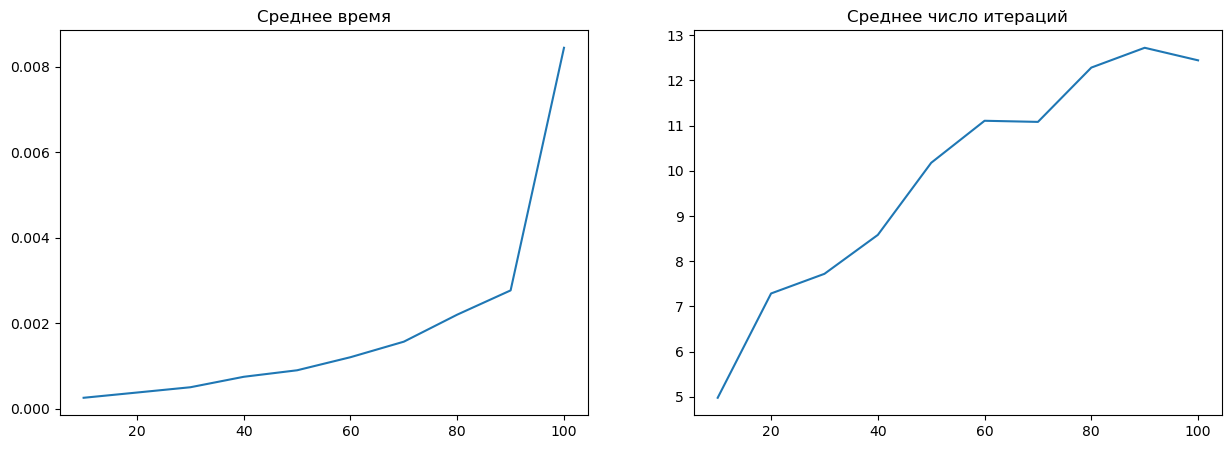

In [359]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

axes[0].plot(n, Average_time)
axes[0].set_title("Среднее время")

axes[1].plot(n, Average_iterations)
axes[1].set_title("Среднее число итераций")

plt.show()

#### Зависимость точности от числа итераций (один тестовый пример размерности 10 и несколько начальных точек)

In [415]:
accuracy = {}

A = result_A[0]
mu = np.ones(10)
constraint_center = np.zeros(10)
res_solver = result_solver[0]

eigenvalues_matrix = np.linalg.eigvals(A)
alpha = 2 * eigenvalues_matrix.min()
beta = 2 * eigenvalues_matrix.max()
step = 2 / (alpha + beta)

for p in range(6):
    accuracy[p] = {"X_res": [], "Y_res": [], "opt": []}
    x = np.random.randint(low=0, high=100, size=10)
    x = x/np.linalg.norm(x, ord=2)
    res_grad = function(x, A, mu)

    while abs(res_solver - res_grad) > ε:
        x = x - step * 2 * A @ (x - mu)
        if ((x - constraint_center)**2).sum()**(1/2) > 1:
            x = x / ((x - constraint_center)**2).sum()**(1/2)
        res_grad = function(x, A, mu)

        accuracy[p]["X_res"].append(x)
        accuracy[p]["Y_res"].append(res_grad)
        accuracy[p]["opt"].append(abs(res_solver - res_grad))

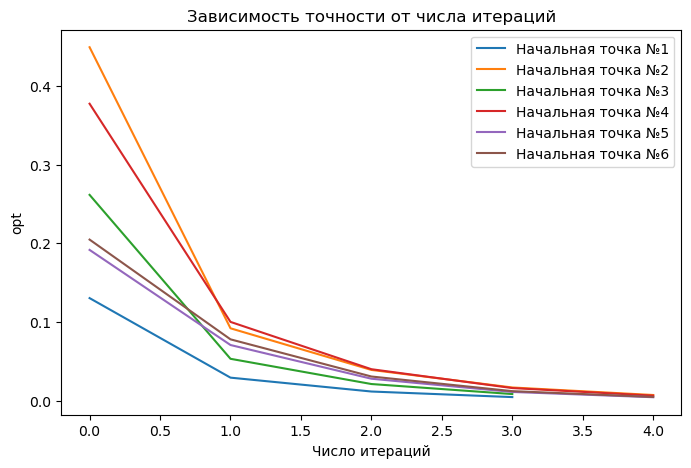

In [429]:
plt.figure(figsize=(8,5))
for p in range(6):
    plt.plot(range(len(accuracy[p]["opt"])), accuracy[p]["opt"], label=f"Начальная точка №{p+1}")
plt.title("Зависимость точности от числа итераций")
plt.xlabel("Число итераций")
plt.ylabel("opt")
plt.legend()
plt.show()

* С учётом ожидаемой точности:

Ожидаемое значение точности $Δ_{t+1}$ на каждом шаге (итерации) можно вывести из формулы скорости сходимости: <br>
$f(x_{t+1}) − f(x^∗) ≤ \frac{β}{2}e^{−\frac{4t}{k+1}}∥x_1-x^*∥^2$, где $k=\frac{β}{α}$ <br>

$Δ_{t+1} ≤ \frac{β}{2}e^{−\frac{4t}{\frac{β}{α}+1}}∥x_1-x^*∥^2$

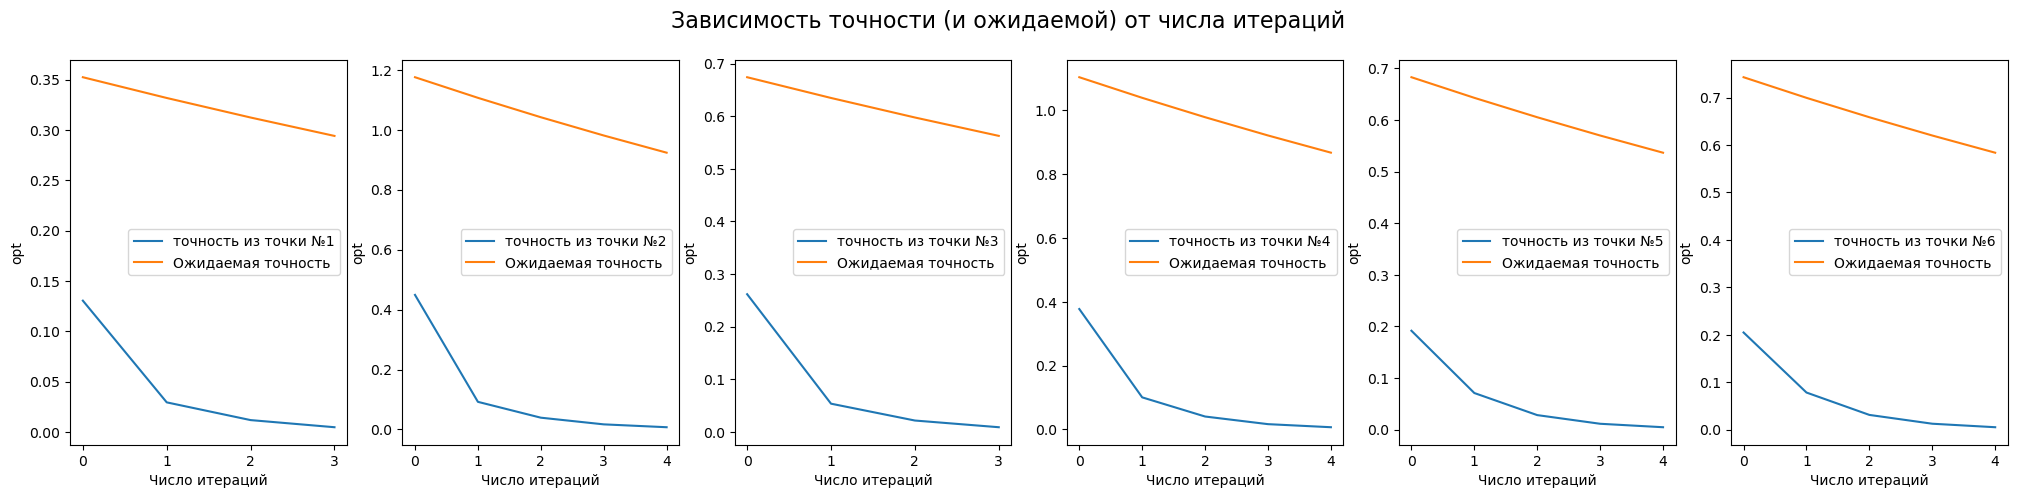

In [430]:
fig, axes = plt.subplots(ncols=6, figsize=(25,5))
fig.suptitle("Зависимость точности (и ожидаемой) от числа итераций", fontsize=16)
for p in range(6):
    deltas = accuracy[p]["opt"]

    expected_deltas = []
    for t in range(0, len(deltas)):
        
        delta = beta/2 * np.exp(-4*t/(beta/alpha + 1)) * (((reult_X_opt_solver[0] - accuracy[p]["X_res"][0])**2).sum()**(1/2))**2
        expected_deltas.append(delta)

    axes[p].plot(range(len(deltas)), deltas, label=f"точность из точки №{p+1}")
    axes[p].plot(range(len(deltas)), expected_deltas, label=f"Ожидаемая точность")
    axes[p].set_xlabel("Число итераций")
    axes[p].set_ylabel("opt")
    axes[p].legend()
plt.show()

Точки сходимости в пределах теоритических предположений, также графики показывают значительное превосходство над теоритическими предположениями.